In [ ]:
# # Install the required libraries
# #SAM
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# #Transformers
# !pip install -q git+https://github.com/huggingface/transformers.git
# #Datasets to prepare data and monai if you want to use special loss functions
# !pip install datasets
# !pip install -q monai
# #Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
# !pip install patchify

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

# Loading data

## Load and Preprocess Data

### Female Mice dataset

In [ ]:
import os
import nibabel as nib
import numpy as np
from skimage import color
from tqdm import tqdm

# paths to the images and labels directories (Note, there are two sets of directories here and in many places as files needed to be stored locally for each group member due to size)
images_path = '/Users/rishienandhan/Desktop/Deep Learning/datasets/FemaleMice/images'
labels_path = '/Users/rishienandhan/Desktop/Deep Learning/datasets/FemaleMice/labels'
# images_path = 'C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/FemaleMice/images'
# labels_path = 'C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/FemaleMice/labels'

large_images = []
large_masks = []

In [ ]:
# Iterate through all files
for image_file in tqdm(os.listdir(images_path)):
    # print(image_file)
    if image_file.endswith('.nii'):
        # Load the image
        image_nifti = nib.load(os.path.join(images_path, image_file))
        image_data = image_nifti.get_fdata()

        # Convert to grayscale
        if image_data.ndim == 3 and image_data.shape[2] == 3:
            image_gray = color.rgb2gray(image_data)
        else:
            image_gray = image_data

        large_images.append(image_gray)

        # get the corresponding label filename
        label_file = image_file.replace('.nii', '-label.nii')
        label_nifti = nib.load(os.path.join(labels_path, label_file))
        label_data = label_nifti.get_fdata()

        large_masks.append(label_data)



100%|███████████████████████████████████████████| 24/24 [00:06<00:00,  3.66it/s]


In [ ]:
# convert to numpy arrays
large_images = np.array(large_images)
large_masks = np.array(large_masks)

print(f'Images shape: {large_images.shape}')
print(f'Masks shape: {large_masks.shape}')

Images shape: (23, 4096, 4096)
Masks shape: (23, 4096, 4096)


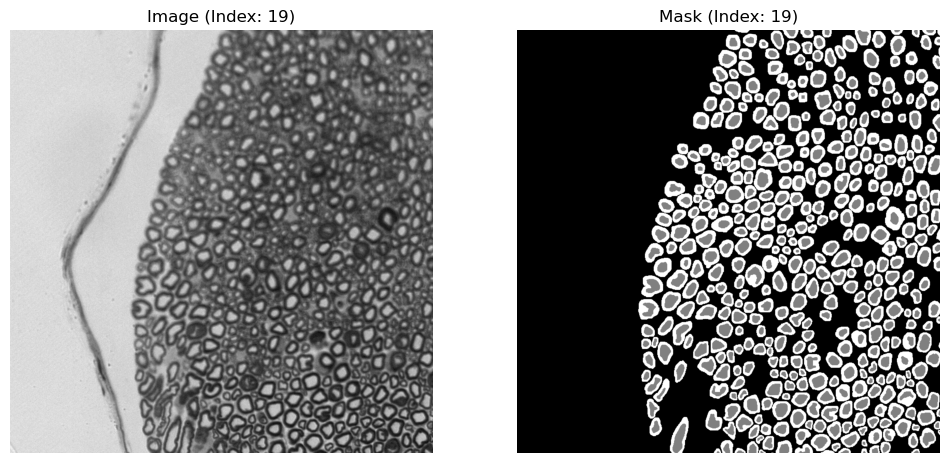

In [ ]:
# Visualize a sample image and mask
random_index = np.random.randint(large_images.shape[0])

selected_image = large_images[random_index]
selected_mask = large_masks[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

In [ ]:
np.unique(selected_mask)

array([0., 1., 2.])

In [ ]:
# Convert:
# - Values of 1 to 0 (background)
# - Values of 2 to 1 (myelin mask)
# - Keep 0 as background
binary_masks = np.where(large_masks == 1, 0, large_masks)
binary_masks = np.where(binary_masks == 2, 1, binary_masks)

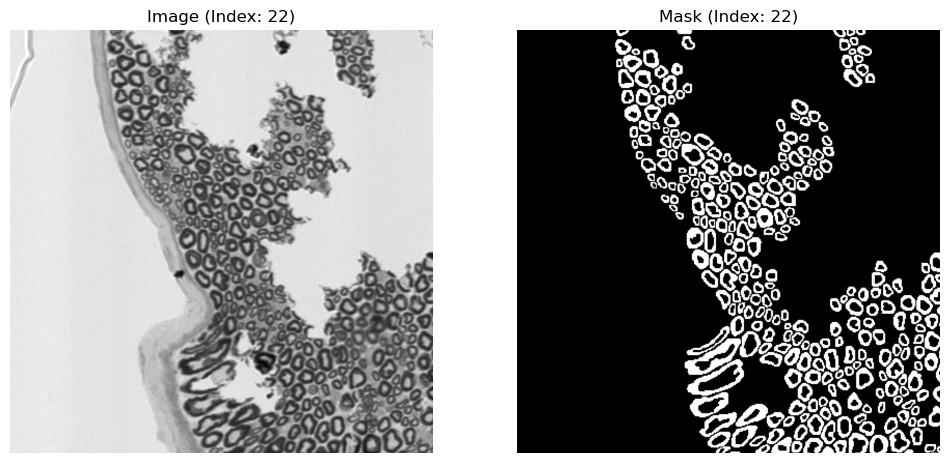

In [ ]:
# Visualize a sample image and mask
random_index = np.random.randint(binary_masks.shape[0])

selected_image = large_images[random_index]
selected_mask = binary_masks[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

In [ ]:
print(large_images.shape)
print(binary_masks.shape)

(23, 4096, 4096)
(23, 4096, 4096)


### Macaque dataset

In [ ]:
import os
import numpy as np
import nibabel as nib

# Paths
base_path = '/Users/rishienandhan/Desktop/Deep Learning/datasets/Macaque'
# base_path = 'C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/Macaque'
data_path = os.path.join(base_path, 'data')
mask_path = os.path.join(base_path, 'segmentation')

# Folder names
sample_folders = ['sample1', 'sample2', 'sample3', 'sample5', 'sample6', 'sample7', 'sample8']

# Initialize lists to store images and masks
images = []
masks = []

In [ ]:
# Load images and masks
for sample in tqdm(sample_folders):
    # Load image
    img_path = os.path.join(data_path, sample)
    img_files = [f for f in os.listdir(img_path) if f.endswith('.nii') or f.endswith('.nii.gz')]
    if img_files:
        img_file = img_files[0]  # Assuming there is only one NIfTI file per folder
        img_nib = nib.load(os.path.join(img_path, img_file))
        image_data = img_nib.get_fdata()
        image_data = np.squeeze(image_data)
        images.append(image_data)

    # Load mask
    mask_path_sample = os.path.join(mask_path, sample)
    mask_files = [f for f in os.listdir(mask_path_sample) if f.endswith('.nii') or f.endswith('.nii.gz')]
    if mask_files:
        mask_file = mask_files[0]  # Assuming there is only one mask per folder
        mask_nib = nib.load(os.path.join(mask_path_sample, mask_file))
        mask_data = mask_nib.get_fdata()
        mask_data = np.squeeze(mask_data)
        masks.append(mask_data)


100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 12.63it/s]


In [ ]:
# convert to numpy arrays
large_images_2 = np.array(images)
large_masks_2 = np.array(masks)

print('Images shape:', large_images_2.shape)
print('Masks shape:', large_masks_2.shape)

Images shape: (7, 2300, 3040)
Masks shape: (7, 2300, 3040)


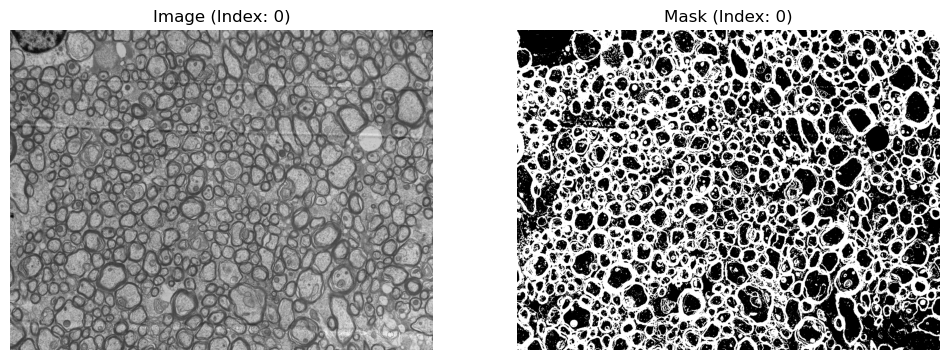

In [ ]:
# Visualize a sample image and mask
random_index = np.random.randint(large_images_2.shape[0])

selected_image = large_images_2[random_index]
selected_mask = large_masks_2[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

In [ ]:
print(large_images_2.shape)
print(large_masks_2.shape)

(7, 2300, 3040)
(7, 2300, 3040)


### AimSeg dataset

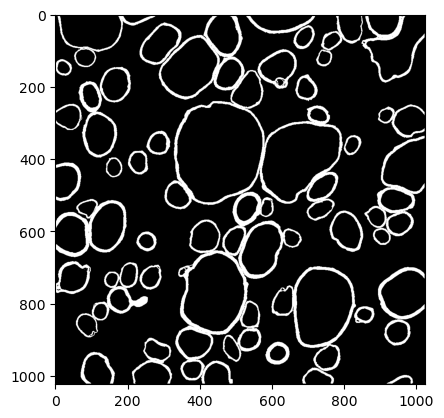

In [ ]:
# Images from AimSeg
aim_seg_images = []
# Iterate through Images and import all images as tiffs to an array
directory_string = "/Users/rishienandhan/Desktop/Deep Learning/datasets/AimSeg/Images/"
# directory_string = 'C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/AimSeg/Images/'
directory = os.fsencode(directory_string)
for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    # Read in tif file
    img = tifffile.imread(directory_string + str(filename))
    img_norm = img #/ np.linalg.norm(img)
    # Pad images to 1024, 1024 with 0s (some were very slightly off)
    y = np.shape(img)[0]
    x = np.shape(img)[1]
    if y < 1024:
        img_norm = np.pad(img_norm, ((0, 1024 - y),(0, 0)))
    if x < 1024:
        img_norm = np.pad(img_norm, ((0, 0),(0, 1024 - x)))
    aim_seg_images.append(img_norm)

# Masks from AimSeg
aim_seg_masks = []
# Iterate through labels and import all images as tiffs to another array
directory_string = "/Users/rishienandhan/Desktop/Deep Learning/datasets/AimSeg/GroundTruth_Semantic/"
# directory_string = 'C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/AimSeg/GroundTruth_Semantic/'
directory = os.fsencode(directory_string)
for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    img = tifffile.imread(directory_string + str(filename))
    # Pad images to 1024
    y = np.shape(img)[0]
    x = np.shape(img)[1]
    if y < 1024:
        img = np.pad(img, ((0, 1024 - y),(0, 0)))
    if x < 1024:
        img = np.pad(img, ((0, 0),(0, 1024 - x)))
    # Binarize mask to only Myelin Sheath
    for i in range(np.shape(img)[0]):
        for j in range(np.shape(img)[1]):
            if img[i][j] == 1.:
                img[i][j] = 1
            else:
                img[i][j] = 0
    aim_seg_masks.append(img)

# Visualize Example
plt.imshow(aim_seg_masks[0], cmap='gray')
plt.show()

In [ ]:
large_images_3 = np.array(aim_seg_images)
large_masks_3 = np.array(aim_seg_masks)

In [ ]:
print(large_images_3.shape)
print(large_masks_3.shape)

(8, 1024, 1024)
(8, 1024, 1024)


In [ ]:
np.max(large_images_3[0])

109590.69

### AxonDeepSeg dataset

In [ ]:
from PIL import Image

In [ ]:
# Images from Axon Deep Seg
ads_images = []
ads_masks = []
# directory_string = "C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/DeepAxonSeg/data/"
directory_string = "/Users/rishienandhan/Desktop/Deep Learning/datasets/DeepAxonSeg/data/"
directory = os.fsencode(directory_string)
for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    # Open PNG File as grayscale
    img = Image.open(directory_string + str(filename)).convert('L')
    ads_images.append(img)

# Masks from Axon Deep Seg
# directory_string = "C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/DeepAxonSeg/labels/"
directory_string = "/Users/rishienandhan/Desktop/Deep Learning/datasets/DeepAxonSeg/labels/"
directory = os.fsencode(directory_string)
for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    # Open PNG File as grayscale
    img = np.array(Image.open(directory_string + str(filename)).convert('L'))
    # Binarize Mask using very high threshold (Already binarized on import, but converting to 0 and 1 only)
    for i in range(np.shape(img)[0]):
        for j in range(np.shape(img)[1]):
            if img[i][j] >= 230:
                img[i][j] = 1
            else:
                img[i][j] = 0
    ads_masks.append(img)

10
10


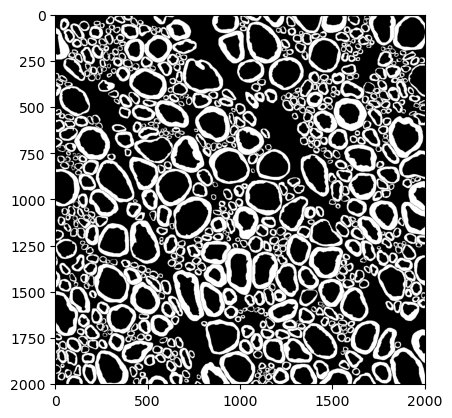

array([0, 1], dtype=uint8)

In [ ]:
# Show number of samples and visualize an example
print(len(ads_images))
print(len(ads_masks))
plt.imshow(ads_masks[1], cmap='gray')
plt.show()
# Confirm binarization of masks now as 0 and 1
np.unique(ads_masks[1])

## Patchify

Now, let us divide these large images into smaller patches for training. We use the patchify library's patchify function and implement custom code to group the patches together into an array.

In [ ]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [ ]:
def patch_large_image(large_images, large_masks):
    all_img_patches = []
    for img in range(large_images.shape[0]):
        large_image = large_images[img]
        patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                all_img_patches.append(single_patch_img)

    images = np.array(all_img_patches)

    #Let us do the same for masks
    all_mask_patches = []
    for img in range(large_masks.shape[0]):
        large_mask = large_masks[img]
        patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):

                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = (single_patch_mask).astype(np.uint8) #/ 255.
                all_mask_patches.append(single_patch_mask)

    masks = np.array(all_mask_patches)
    return images, masks

### Generate Patches

Female mice dataset:

In [ ]:
images_1, masks_1 = patch_large_image(large_images, binary_masks)

In [ ]:
print(images_1.shape)
print(masks_1.shape)

(5888, 256, 256)
(5888, 256, 256)


In [ ]:
print(np.max(images_1[0]))
print(np.max(masks_1[0]))

245.7779
0


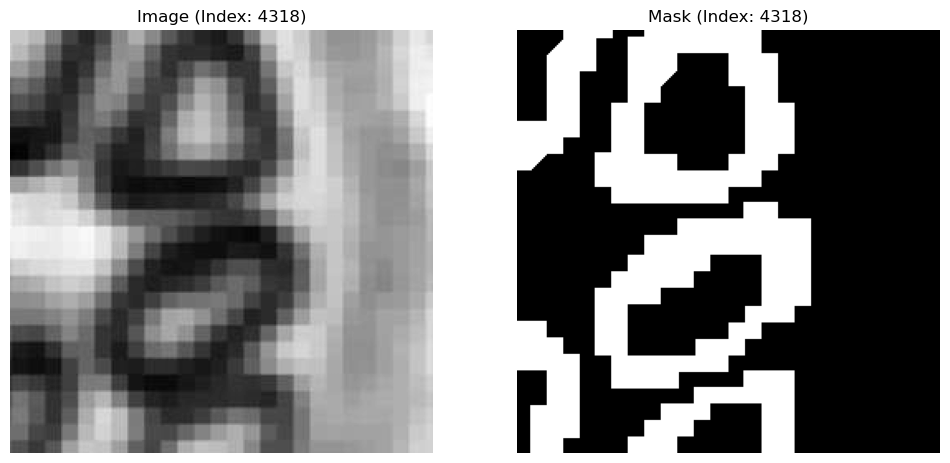

In [ ]:
# Visualize a sample image and mask
random_index = np.random.randint(images_1.shape[0])

selected_image = images_1[random_index]
selected_mask = masks_1[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

Macaque dataset:

In [ ]:
print(large_images_2.shape)
print(large_masks_2.shape)

(7, 2300, 3040)
(7, 2300, 3040)


In [ ]:
images_2, masks_2 = patch_large_image(large_images_2, large_masks_2)

In [ ]:
print(images_2.shape)
print(masks_2.shape)

(616, 256, 256)
(616, 256, 256)


In [ ]:
print(np.max(images_2[0]))
print(np.max(masks_2[0]))

201.0
1


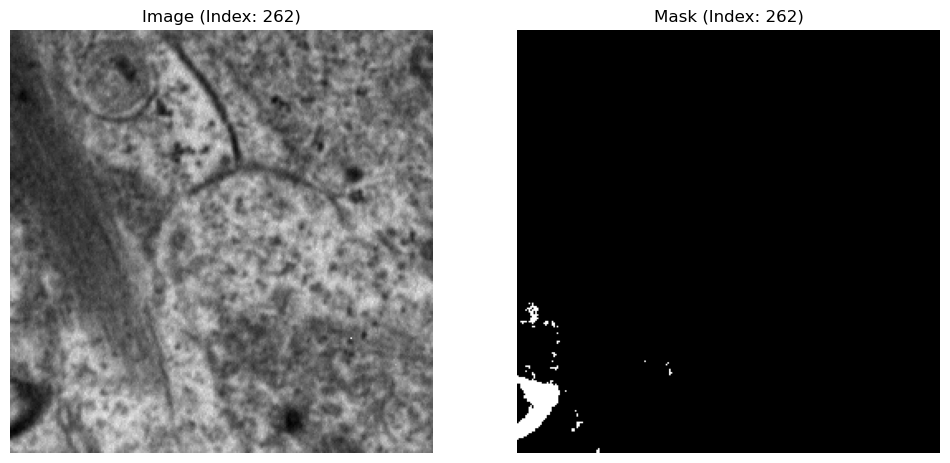

In [ ]:
# Visualize a sample image and mask
random_index = np.random.randint(images_2.shape[0])

selected_image = images_2[random_index]
selected_mask = masks_2[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

AimSeg dataset:

In [ ]:
print(large_images_3.shape)
print(large_masks_3.shape)

(8, 1024, 1024)
(8, 1024, 1024)


In [ ]:
images_3, masks_3 = patch_large_image(large_images_3, large_masks_3)

In [ ]:
print(images_3.shape)
print(masks_3.shape)

(128, 256, 256)
(128, 256, 256)


In [ ]:
np.max(images_3[0])

97223.984

In [ ]:
print(np.max(images_3[0]))
print(np.max(masks_3[0]))

97223.984
1


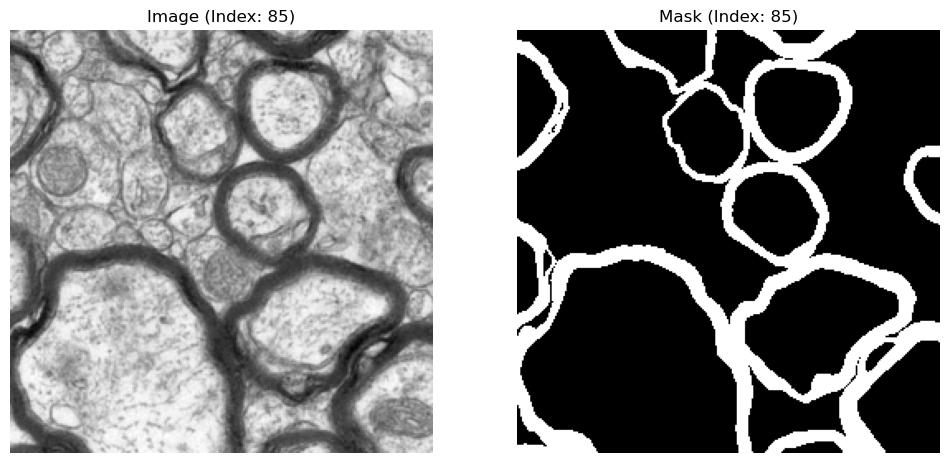

In [ ]:
# Visualize a sample image and mask
random_index = np.random.randint(images_3.shape[0])

selected_image = images_3[random_index]
selected_mask = masks_3[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

AxonDeepSeg dataset

In [ ]:
all_img_patches = []
for img in range(len(ads_images)):
    large_image = np.array(ads_images[img])
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images_4 = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(len(ads_masks)):
    large_mask = np.array(ads_masks[img])
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask).astype(np.uint8) #/ 255.
            all_mask_patches.append(single_patch_mask)

masks_4 = np.array(all_mask_patches)

In [ ]:
print(images_4.shape)
print(masks_4.shape)

(183, 256, 256)
(183, 256, 256)


In [ ]:
print(np.max(images_4[0]))
print(np.max(masks_4[0]))

255
1


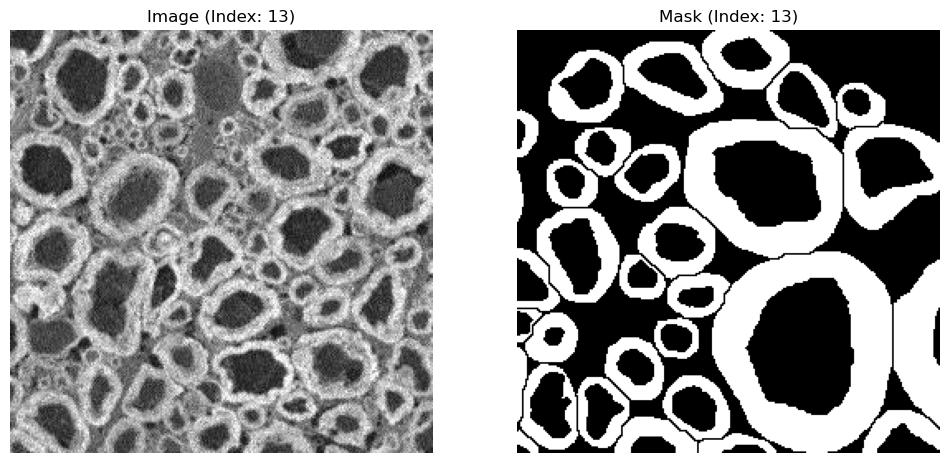

In [ ]:
# Visualize a sample image and mask
random_index = np.random.randint(images_4.shape[0])

selected_image = images_4[random_index]
selected_mask = masks_4[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

### Combine images

In [ ]:
# Combine all images and masks into 2 numpy tensors
images = np.concatenate((images_1, images_2, images_3, images_4), axis=0)
masks = np.concatenate((masks_1, masks_2, masks_3, masks_4), axis=0)
print("Image shape:", images.shape)
print("Mask shape:", masks.shape)

Image shape: (6815, 256, 256)
Mask shape: (6815, 256, 256)


### Normalize images to [0,1]

Simple normalization scheme of all images to standardize all image values between 0 and 255

In [ ]:
def image_adjust(im):
    adjusted_I = ((im - np.min(im)) * (1/(np.max(im) - np.min(im))*255.0)).astype('uint8')
    return adjusted_I

In [ ]:
for i in tqdm(np.arange(images.shape[0])):
    images[i] = image_adjust(images[i])

100%|█████████████████████████████████████| 6815/6815 [00:03<00:00, 2150.63it/s]


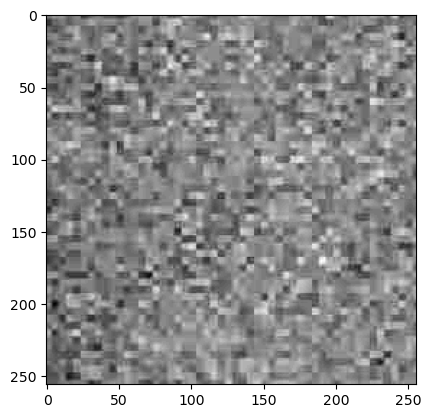

In [ ]:
plt.imshow(images[300], cmap = 'gray')
plt.show()

In [ ]:
images[1]

array([[225., 225., 224., ..., 180., 177., 173.],
       [225., 225., 224., ..., 180., 177., 173.],
       [225., 225., 224., ..., 180., 176., 172.],
       ...,
       [ 96.,  96.,  95., ..., 203., 191., 161.],
       [ 97.,  97.,  96., ..., 204., 191., 159.],
       [ 99.,  99.,  99., ..., 206., 191., 159.]])

In [ ]:
np.max(images[1])

255.0

In [ ]:
# save image as PNGs

# Create a directory to save the images if it doesn't exist
save_dir = 'png_images'

# save each grayscale image as a PNG file
for i, img_array in tqdm(enumerate(images)):
    img = Image.fromarray(img_array.astype(np.uint8))
    img.save(os.path.join(save_dir, f'image_{i}.png'))

In [ ]:
# save masks as PNGs

# Create a directory to save the masks
save_dir = 'png_masks'

# save each grayscale image as a PNG file
for i, img_array in tqdm(enumerate(masks)):
    img = Image.fromarray(img_array.astype(np.uint8))
    img.save(os.path.join(save_dir, f'mask_{i}.png'))

## Reload Processed Data
Using the directories png_images and png_masks, reload the saved data here for further use. This method was also used before training to convert the images from grayscale to RGB using the Pillow library.

In [ ]:
# Re-load Image PNGs as Pillow images
rgb_images = []
save_dir = 'png_images'

# reload the images as RGB and store them back in a list (number of samples hard-coded)
for i in tqdm(range(6815)):
    img_path = os.path.join(save_dir, f'image_{i}.png')
    img = Image.open(img_path).convert('RGB')  # Load and convert to RGB
    rgb_images.append(np.array(img))  # Convert PIL Image to numpy array and store

images = np.array(rgb_images)
print(images.shape)

6815it [00:27, 248.82it/s]
100%|█████████████████████████████████████| 6815/6815 [00:04<00:00, 1461.02it/s]


(6815, 256, 256, 3)


In [ ]:
# Re-load Mask PNGs as Numpy Arrays
reload_masks = []
save_dir = 'png_masks'

# reload the masks and store them back in a list (number of samples hard-coded)
for i in tqdm(range(6815)):
    img_path = os.path.join(save_dir, f'mask_{i}.png')
    img = Image.open(img_path).convert('L')  # Load and maintain grayscale
    reload_masks.append(np.array(img))  # Convert PIL Image to numpy array and store

masks = np.array(reload_masks)

In [ ]:
# images = images / 255. # DO NOT NORMALIZE

In [ ]:
np.max(images[100])

1.0

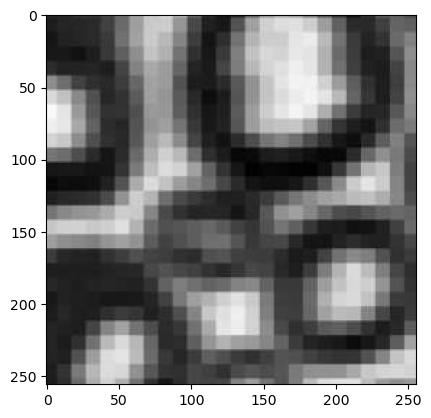

In [ ]:
# Show a single image patch to confirm it is loaded correctly
plt.imshow(images[100], cmap='gray')
plt.show()

### Delete empty binary mask pairs

Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [ ]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (3707, 256, 256, 3)
Mask shape: (3707, 256, 256)


Let us create a 'dataset' object that serves us input images and masks for the rest of our journey.

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}
#.convert('RGB')
# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

Let us make sure our images and masks (labels) are all loaded appropriately

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3707
})

In [ ]:
from PIL import Image, ImageOps
# im2 = ImageOps.grayscale(im1)

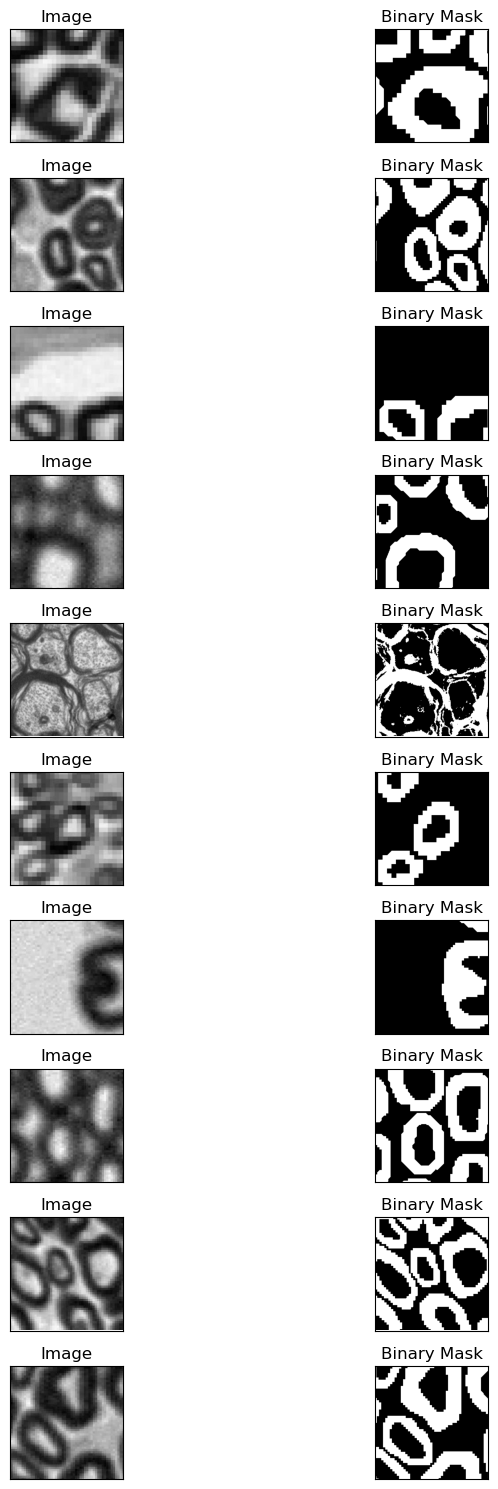

In [ ]:
# Plotting function for 10 sample images with masks
def plot_images_with_masks(dataset, num_images=10):
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 15))

    for i, idx in enumerate(indices):
        example_image = dataset[idx]["image"]
        example_mask = dataset[idx]["label"]
        axes[i, 0].imshow(np.array(example_image), cmap='gray') #ImageOps.grayscale(example_image)
        axes[i, 0].set_title('Image')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].set_xticklabels([])
        axes[i, 0].set_yticklabels([])

        axes[i, 1].imshow(example_mask, cmap='gray')
        axes[i, 1].set_title('Binary Mask')
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])
        axes[i, 1].set_xticklabels([])
        axes[i, 1].set_yticklabels([])

    plt.tight_layout()
    plt.show()

# Call the function to plot 10 random images with their masks
plot_images_with_masks(dataset, 10)

## Getting a Dataset Ready for Training

The following code for setting up the SAM training was adapted from this notebook: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0).to(torch.float32) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base", do_rescale=False)

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
train_dataset

In [ ]:
import torch

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
# Pin memory true since data is loaded in cpu and we need it in gpu
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=False, pin_memory=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([4, 3, 1024, 1024])
original_sizes torch.Size([4, 2])
reshaped_input_sizes torch.Size([4, 2])
input_boxes torch.Size([4, 1, 4])
ground_truth_mask torch.Size([4, 256, 256])


In [ ]:
batch["pixel_values"].shape

torch.Size([4, 3, 1024, 1024])

In [ ]:
batch["ground_truth_mask"].shape

torch.Size([4, 256, 256])

# Loading Model

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Use DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)

model.train()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, checkpoint_dir):
  checkpoint = {
    "epoch": epoch,
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "mean_loss": loss
  }

  torch.save(checkpoint, checkpoint_dir + f'checkpoint_at_epoch_{epoch}.pt')

In [ ]:
checkpoint_dir = "model_checkpoints/"

In [ ]:
# checking for GPU access:
print(device)

mps


### Train model

Training was set to 10 epochs and inturrupted when sufficient time had passed (6 epochs).

In [ ]:
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    save_checkpoint(epoch, model, optimizer, mean(epoch_losses), checkpoint_dir)

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [3:10:03<00:00, 36.91s/it]


EPOCH: 0
Mean loss: 0.6899453530805396


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [2:26:50<00:00, 28.51s/it]


EPOCH: 1
Mean loss: 0.6037473520414729


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [2:27:12<00:00, 28.58s/it]


EPOCH: 2
Mean loss: 0.5808589691868877


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [2:33:22<00:00, 29.78s/it]


EPOCH: 3
Mean loss: 0.5659444842330846


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [2:43:13<00:00, 31.69s/it]


EPOCH: 4
Mean loss: 0.5545135440371183


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [3:15:49<00:00, 38.02s/it]


EPOCH: 5
Mean loss: 0.545780752758378


  3%|██▌                                                                            | 10/309 [11:00<5:28:56, 66.01s/it]


KeyboardInterrupt: 

We trained our model for 6 epochs with batch size 12, which took a total training time of 16 hours 36 minutes on a local dev environment using NVIDIA RTX 4080 GPU.

# Inference

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

We load the model weights after training for 6 epochs, to perform inference on further images.

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
axon_model = SamModel(config=model_config)
# Update the model by loading the weights from saved file.
# Indexed from 0 so epoch_1 below is the second epoch
checkpoint = torch.load("model_checkpoints/checkpoint_at_epoch_5.pt", map_location=torch.device('mps'))
axon_model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "mps" if torch.backends.mps.is_available() else "cpu"
axon_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
val_dataset = dataset

### Prompt Testing

In [ ]:
# IF WE WANT TO USE A GRID OF POINTS AS PROMPT

"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""

# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 7

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

(1, 1, 49, 2)


In [ ]:
# IF WE WANT BOUNDING BOX

def get_total_bounding_box(W = 256, H = 256, x_min = 0, y_min = 0, x_max = 256, y_max = 256):
  # add perturbation if inputted bounding box coordinates
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))

  bbox = [x_min, y_min, x_max, y_max]

  return bbox

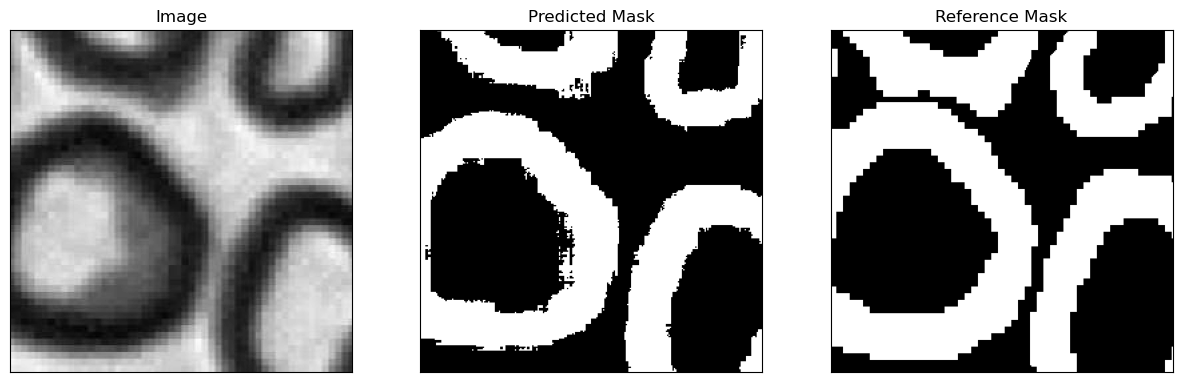

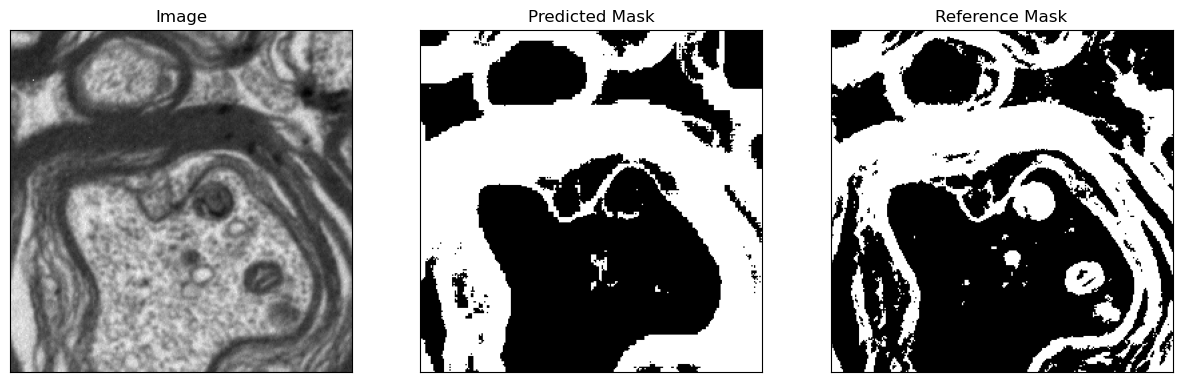

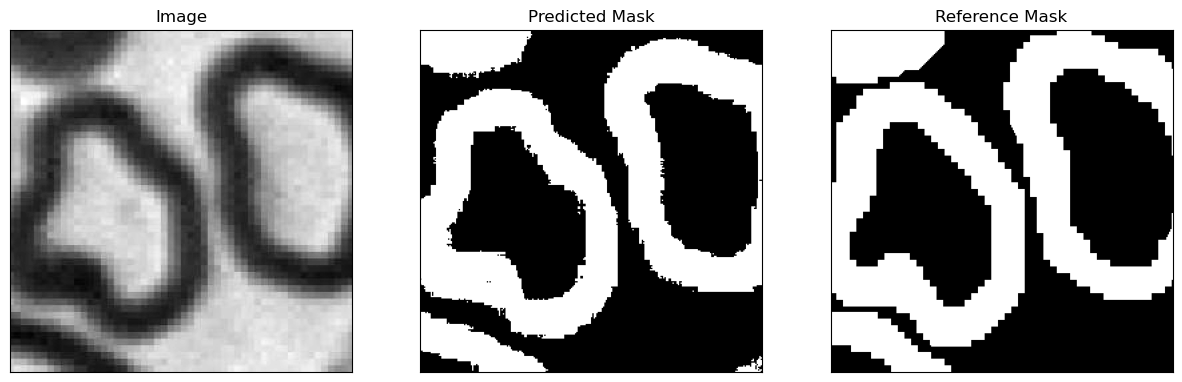

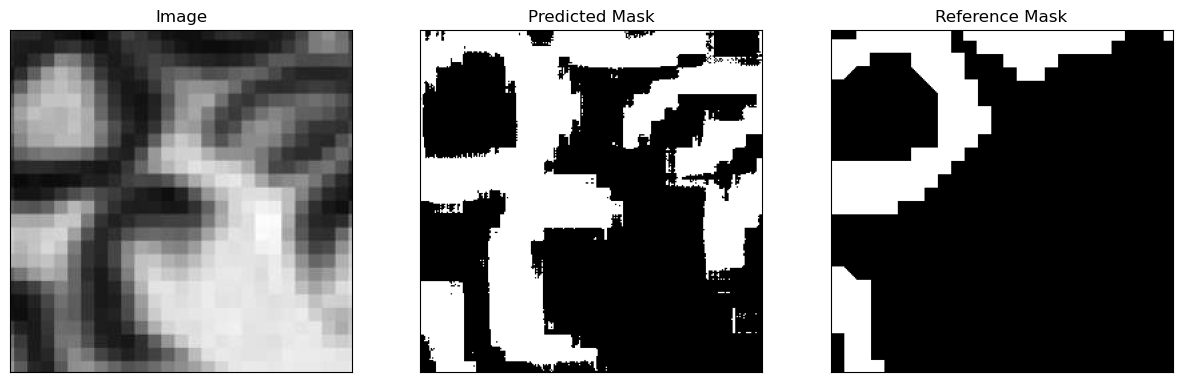

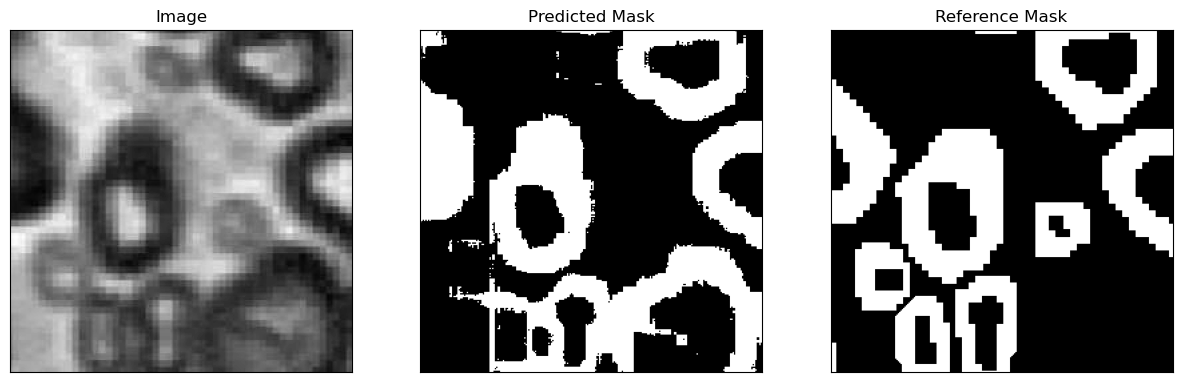

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# Predict myelin binary masks for 5 random samples from 'val' set
for i in range(5):
  # let's take a random sample from validation dataset
  idx = random.randint(0, 3707)

  # load image
  test_image = val_dataset[idx]["image"]

  # get box prompt based on ground truth segmentation map
  ground_truth_mask = np.array(val_dataset[idx]["label"])
  prompt = get_bounding_box(ground_truth_mask)

  # prepare image + box prompt for the model
  # inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
  # inputs = processor(test_image, input_points=input_points, return_tensors="pt")

  # Now try with bounding box that covers whole image since we don't have ground truth
  custom_prompt = get_total_bounding_box(test_image.size[0], test_image.size[1], 0, 0, test_image.size[0], test_image.size[1])
  inputs = processor(test_image, input_boxes=[[custom_prompt]], return_tensors="pt")

  # Move the input tensor to the GPU if it's not already there
  inputs = {k: v.to(torch.float32).to(device) for k, v in inputs.items()}

  axon_model.eval()

  # forward pass
  with torch.no_grad():
      outputs = axon_model(**inputs, multimask_output=False)

  # apply sigmoid
  medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
  medsam_seg = (medsam_seg_prob > 0.50).astype(np.uint8)


  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Plot the first image on the left
  axes[0].imshow(np.array(test_image.convert('L')), cmap='gray')
  axes[0].set_title("Image")

  # Plot the second image on the right
  axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
  axes[1].set_title("Predicted Mask")

  # # Plot the second image on the right
  # axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
  # axes[2].set_title("Probability Map")

  # Plot the ground truth binary mask
  axes[2].imshow(np.array(val_dataset[idx]["label"]), cmap='gray')
  axes[2].set_title("Reference Mask") # ground truth binary mask

  # Hide axis ticks and labels
  for ax in axes:
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xticklabels([])
      ax.set_yticklabels([])

  # Display the images side by side
  plt.show()


**Observations:**

Now, we generate probability maps for 5 random images from the 'val' split of our custom dataset and compare it against the ground truth masks.

We test various thresholds for converting the probability masks to binary masks and set our threshold accordingly.

We observe that with only 6 epochs of training, the model is able to generate excellent results in most cases. Incomplete Myelin Sheaths are detected by our model, even though the ground truth does not identify it, showing a abnormalities that would potentially go unnoticed. The model does somewhat struggle with smaller structures.

## Predict Myelin Segmentation Masks on New Image

In [ ]:
from patchify import unpatchify

In [ ]:
# Take array of patchify'd images and a the input image for its shape and stitch the patches together
def my_unpatchify(patches, input_image):
    # Get the cropped image size
    input_x = input_image.shape[0] - (input_image.shape[0] % 256)
    input_y = input_image.shape[1] - (input_image.shape[1] % 256)
    # Determine the layout of the patches
    patches_dim = (int(input_x/256), int(input_y/256))
    output_arr = np.zeros((input_x, input_y))
    patches_counter = 0

    # Insert the patches into the output array
    for i in range(patches_dim[0]):
        for j in range(patches_dim[1]):
            output_arr[i*256:(1+i)*256][j*256:(1+j)*256] = patches[patches_counter]
            patches_counter+=1

    return output_arr


In [ ]:
# Driver function for taking in an input image and generating a myelin segmentation mask
def find_my_axon(input_image):
    input_image = np.array(input_image)
    patches = patchify(input_image, (256, 256), step=256)
    cropped_x = input_image.shape[0] - (input_image.shape[0] % 256)
    cropped_y = input_image.shape[1] - (input_image.shape[1] % 256)
    pred_masks_zeros = np.zeros((patches.shape[0], patches.shape[1], 256, 256))
    # print('pred_masks_zeros', pred_masks_zeros.shape)
    for row in np.arange(patches.shape[0]):
        for col in np.arange(patches.shape[1]):
            i, j = row, col

            # select patch for segmentation
            random_array = patches[i, j]
            single_patch = Image.fromarray(random_array).convert('RGB')

            # prepare image + box prompt for the model
            # inputs = processor(test_image, input_points=input_points, return_tensors="pt")

            # Now try with bounding box that covers whole image since we don't have ground truth
            custom_prompt = get_total_bounding_box(single_patch.size[0], single_patch.size[1], 0, 0, single_patch.size[0], single_patch.size[1])
            inputs = processor(single_patch, input_boxes=[[custom_prompt]], return_tensors="pt")

            # Move the input tensor to the GPU if it's not already there
            inputs = {k: v.to(torch.float32).to(device) for k, v in inputs.items()}

            axon_model.eval()

            # forward pass
            with torch.no_grad():
              outputs = axon_model(**inputs, multimask_output=False)

            # apply sigmoid
            medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
            # convert soft mask to hard mask
            medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
            medsam_seg = (medsam_seg_prob > 0.50).astype(np.uint8)
            pred_masks_zeros[row][col][:][:] = np.array(medsam_seg)

    predicted_mask = unpatchify(pred_masks_zeros, (cropped_x, cropped_y))

    return predicted_mask


In [ ]:
# Import test image
large_test_image = Image.open('/Users/rishienandhan/Desktop/Deep Learning/datasets/DeepAxonSeg/data/sub-rat1_sample-data1_SEM.png').convert('L')


In [ ]:
# Find mask
predicted_mask = find_my_axon(large_test_image)

(924, 1278)
pred_masks_zeros (3, 4, 256, 256)


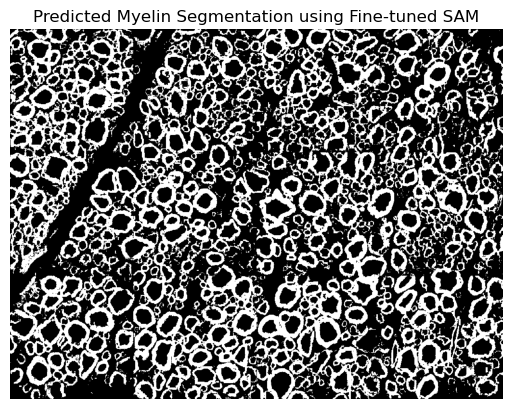

In [ ]:
# Show resulting mask
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Myelin Segmentation using Fine-tuned SAM')
plt.axis('off')
plt.savefig('finetune_mask.png', bbox_inches='tight', pad_inches=0.05)
plt.show()

In [ ]:
# Since we use patchify, we must crop our images to a shape multiple of patch_size
def crop_image(input_image, patch_size=256):
    cropped_x = input_image.shape[0] - (input_image.shape[0] % patch_size)
    cropped_y = input_image.shape[1] - (input_image.shape[1] % patch_size)
    test = np.array(large_test_image)[0:cropped_x, 0:cropped_y]
    return test

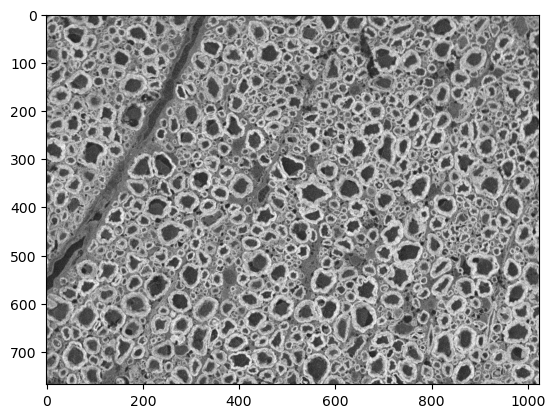

In [ ]:
# Show original image cropped to size of mask
original_image = crop_image(np.array(large_test_image), 256)
plt.imshow(original_image, cmap='gray')
plt.show()

In [ ]:
# Take an image and mask, convert the image to RGB and overlay the mask as cyan
def overlay_predicted_mask(image, mask):
    image = image.convert('RGB')
    image = np.array(image)
    image = crop_image(image)
    for i in range(np.shape(image)[0]):
        for j in range(np.shape(image)[1]):
            if mask[i][j] > 0:
                image[i][j][0] = 0
                image[i][j][1] = 255
                image[i][j][2] = 220
    return image

In [ ]:
# Overlay test image with generate mask
large_test_image = large_test_image.convert('RGB')
overlay_img = overlay_predicted_mask(large_test_image, predicted_mask)

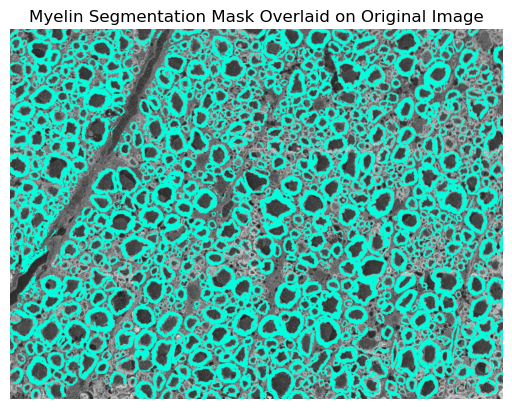

In [ ]:
# Show overlaid result
plt.imshow(overlay_img)
plt.axis('off')
plt.title('Myelin Segmentation Mask Overlaid on Original Image')
plt.show()

## Performance Metric

In [ ]:
from sklearn.model_selection import train_test_split

_, data_test, _, labels_test = train_test_split(filtered_images, filtered_masks, test_size=0.20, random_state=42)
print('data_test shape: ', data_test.shape)
print('labels_test shape: ', labels_test.shape)

data_test shape:  (742, 256, 256, 3)
labels_test shape:  (742, 256, 256)


In [ ]:
# Calculate Dice Coefficient of a true mask and predicted mask
def dice_coefficient(y_true, y_pred):
    # Convert to boolean arrays, True for 1 and False for 0
    y_true_f = y_true.astype(bool)
    y_pred_f = y_pred.astype(bool)

    # Compute the intersection of the two arrays
    intersection = np.logical_and(y_true_f, y_pred_f).sum()

    # Compute the count of positives in each array
    true_sum = y_true_f.sum()
    pred_sum = y_pred_f.sum()

    # Compute the Dice coefficient
    dice = (2. * intersection) / (true_sum + pred_sum)

    return dice

In [ ]:
# Predict binary mask and compute Dice score for our test images:
dice_list = [] #list to hold dice scores of all test images
for i in tqdm(range(data_test.shape[0])):
    img = data_test[i]
    # make prediction
    single_patch = Image.fromarray(img) #.convert('RGB')

    # prepare image + box prompt for the model
    # inputs = processor(test_image, input_points=input_points, return_tensors="pt")

    # Now try with bounding box that covers whole image since we don't have ground truth
    custom_prompt = get_total_bounding_box(single_patch.size[0], single_patch.size[1], 0, 0, single_patch.size[0], single_patch.size[1])
    inputs = processor(single_patch, input_boxes=[[custom_prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(torch.float32).to(device) for k, v in inputs.items()}

    axon_model.eval()

    # forward pass
    with torch.no_grad():
      outputs = axon_model(**inputs, multimask_output=False)

    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.50).astype(np.uint8)

    # Compute Dice score:
    dice_score = dice_coefficient(labels_test[i], medsam_seg)
    dice_list.append(dice_score)

100%|█████████████████████████████████████████| 742/742 [09:14<00:00,  1.34it/s]


In [ ]:
# Average dice score across test samples:
avg = sum(dice_list)/len(dice_list)
print('Average Dice Score: ', avg)

Average Dice Score:  0.7209173482216156


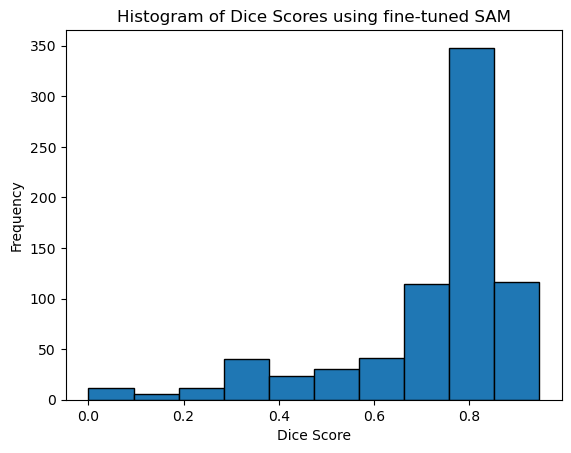

In [ ]:
# Histogram of dice score across test samples:

# plotting labelled histogram
plt.hist(dice_list, edgecolor='black')
plt.title('Histogram of Dice Scores using fine-tuned SAM')
plt.xlabel('Dice Score')
plt.ylabel('Frequency')
plt.savefig('dice_finetuned.png', bbox_inches='tight', pad_inches=0.05)
plt.show()

## Compare Finetuned SAM model performance to baseline model without re-training

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base", do_rescale=False)

In [ ]:
# Reimport test image and predict mask on baseline SAM
large_test_image = Image.open('/Users/rishienandhan/Desktop/Deep Learning/datasets/DeepAxonSeg/data/sub-rat1_sample-data1_SEM.png').convert('L')
predicted_mask_baseline = find_my_axon(large_test_image)

(924, 1278)
pred_masks_zeros (3, 4, 256, 256)


In [ ]:
# Overlay result
large_test_image = large_test_image.convert('RGB')
overlay_img_baseline = overlay_predicted_mask(large_test_image, predicted_mask_baseline)

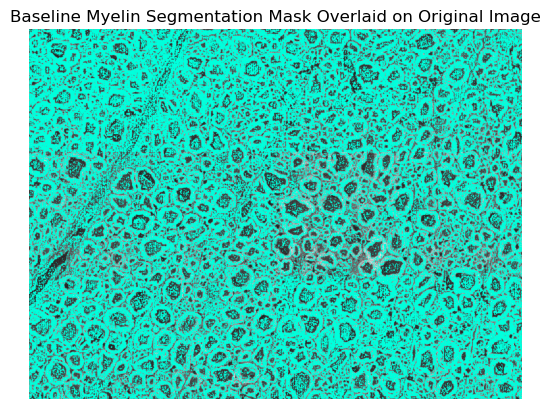

In [ ]:
# Show overlaid result
plt.imshow(overlay_img_baseline)
plt.axis('off')
plt.title('Baseline Myelin Segmentation Mask Overlaid on Original Image')
plt.show()

In [ ]:
# predict binary mask and compute Dice score for our test images using Baseline SAM:
dice_list_baseline = [] #list to hold dice scores of all test images
for i in tqdm(range(data_test.shape[0])):
    img = data_test[i]
    # make prediction
    single_patch = Image.fromarray(img) #.convert('RGB')

    # prepare image + box prompt for the model
    # inputs = processor(test_image, input_points=input_points, return_tensors="pt")

    # Now try with bounding box that covers whole image since we don't have ground truth
    custom_prompt = get_total_bounding_box(single_patch.size[0], single_patch.size[1], 0, 0, single_patch.size[0], single_patch.size[1])
    inputs = processor(single_patch, input_boxes=[[custom_prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(torch.float32).to(device) for k, v in inputs.items()}

    axon_model.eval()

    # forward pass
    with torch.no_grad():
      outputs = axon_model(**inputs, multimask_output=False)

    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.50).astype(np.uint8)

    # Compute Dice score:
    dice_score = dice_coefficient(labels_test[i], medsam_seg)
    dice_list_baseline.append(dice_score)

100%|█████████████████████████████████████████| 742/742 [09:03<00:00,  1.37it/s]


In [ ]:
# Average dice score across test samples:
avg = sum(dice_list_baseline)/len(dice_list_baseline)
print('Average Dice Score: ', avg)

Average Dice Score:  0.3090464102573744


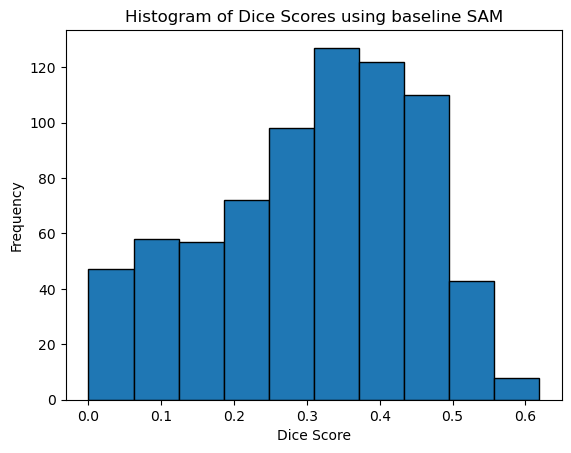

In [ ]:
# Histogram of dice score across test samples:

# plotting labelled histogram
plt.hist(dice_list_baseline, edgecolor='black')
plt.title('Histogram of Dice Scores using baseline SAM')
plt.xlabel('Dice Score')
plt.ylabel('Frequency')
plt.savefig('dice_baseline.png', bbox_inches='tight', pad_inches=0.05)
plt.show()

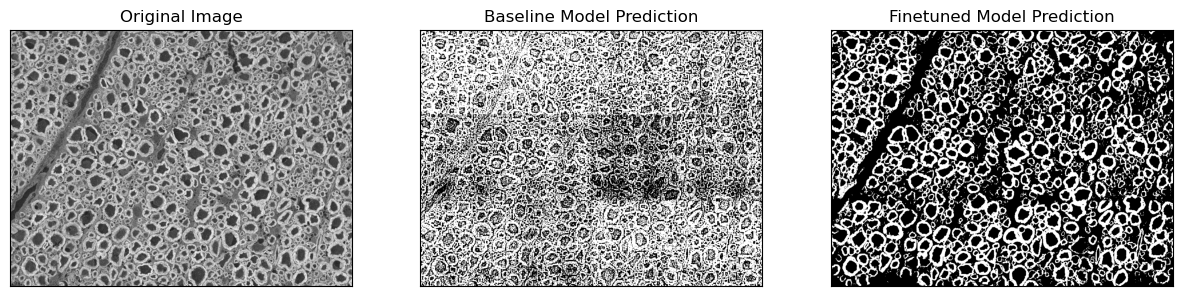

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image on the left
axes[0].imshow(crop_image(np.array(large_test_image)), cmap='gray')
axes[0].set_title("Original Image")

# Plot the baseline model prediction in the middle
axes[1].imshow(predicted_mask_baseline, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Baseline Model Prediction")

# Plot the finetuned model prediction on the right
axes[2].imshow(predicted_mask, cmap='gray')
axes[2].set_title("Finetuned Model Prediction") # ground truth binary mask

# Hide axis ticks and labels
for ax in axes:
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])

# Display the images side by side
plt.savefig('mask_comparision.png', bbox_inches='tight', pad_inches=0.05)
plt.show()


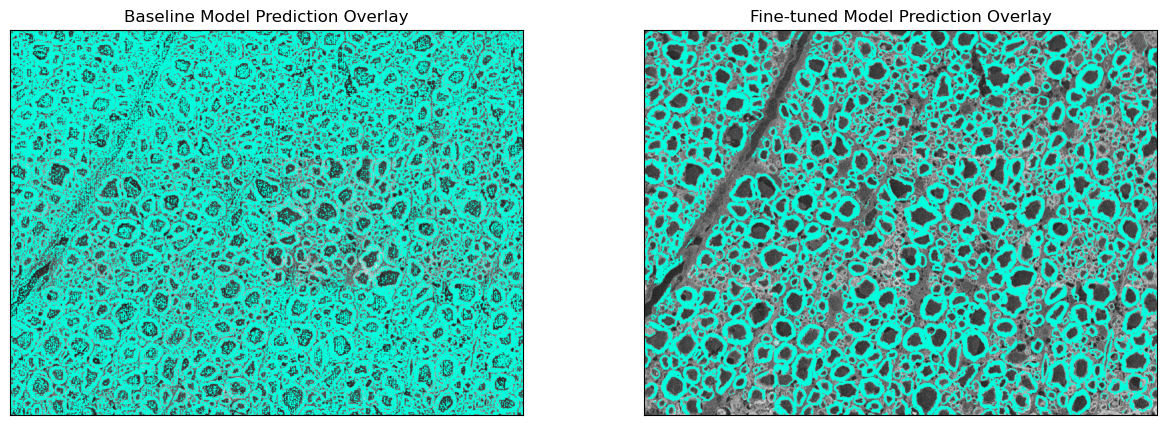

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the baseline model prediction overlay on the left
axes[0].imshow(overlay_img_baseline)
axes[0].set_title("Baseline Model Prediction Overlay")

# Plot the finetuned model prediction overlay on the right
axes[1].imshow(overlay_img)
axes[1].set_title("Fine-tuned Model Prediction Overlay")

# Hide axis ticks and labels
for ax in axes:
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])

# Display the images side by side
plt.savefig('overlay_comparision.png', bbox_inches='tight', pad_inches=0.05)
plt.show()


The End.